Notes

Slide 30, no factor of 2 for Ld

Slide 28 clarify which region is n-type or p-type. Bullet points 3 and 4 are contradictory

Finite difference matrix incorrect, line 3 should be 0 1 -4 0 0 1 0 0 0

Slide 31 boundary conditions should not be multiplied by h^2

In [1]:
# define constants
import time
start_time = time.time()
import math

q = 1.602e-19
eps = 11.68*8.85e-12
boltzmann = 1.38e-23
ni_cm = 1e10
ni = ni_cm*1e6
T = 298
Vt = boltzmann*T/q
Ld = math.sqrt(eps*Vt/q/ni)

In [2]:
# from sympy import symbols, init_printing
import symengine as se
from symengine import symbols
from symengine.lib.symengine_wrapper import DenseMatrix, Symbol
import numpy as np
from matplotlib import pylab as plt
%matplotlib notebook
#sympy.init_printing(use_latex=True)

box_length = 10e-6*3/Ld
dimension = 18
elements = dimension*dimension
h_val = box_length/dimension
Nd_val = -1e15/ni_cm
Na_val = 1e17/ni_cm
#bc_val = 0.0
bc_val = 1/Vt
max_bc = 1/Vt
#v_sym = np.full((dimension, dimension), None, dtype=sympy.symbol.Symbol)
v_sym = DenseMatrix(dimension, dimension, [0]*elements)
index = 0
for x in range(dimension):
    for y in range(dimension):
        v_sym[x, y] = Symbol('psi_'+str(index))
        index += 1

def get_xy(index):
    x = math.floor(index/dimension)
    y = index - x*dimension
    return (x, y)
def to_index(x, y):
    return y + x*dimension

def to_val(sym):
    return sym.subs(h, h_val).subs(Na, Na_val).subs(Nd, Nd_val).subs(bc, bc_val)

In [3]:
def get_doping(x, y):
    cutoff = math.floor(dimension/2.0)
    if (x+y <= cutoff):
        return Nd
    else:
        return Na  

In [4]:
def get_bc(x, y, pos):
    # left is 0, top is 1, right is 2, bottom is 3
    grid_scale = dimension/3
    if pos == 0 and x == 0:
        if y < grid_scale:
            return bc
        else:
            return 0
    elif pos == 1 and y == 0:
        if x < grid_scale:
            return bc
        else:
            return 0
    else:
        return 0

def get_neighbor(x, y, pos, matrix=v_sym):
    # left is 0, top is 1, right is 2, bottom is 4
    offsets = [(-1, 0), (0, -1), (1, 0), (0, 1)]
    x += offsets[pos][0]
    y += offsets[pos][1]
    if x < 0 or x >= dimension or y < 0 or y >= dimension:
        return 0
    else:
        return matrix[x, y]

def get_top(x, y):
    return get_bc(x, y, 1) + get_neighbor
    

In [5]:
# full formulation
h = Symbol('h')
Nd = Symbol('Nd')
Na = Symbol('Na')
bc = Symbol('bc')
#v_func_sym = np.full((dimension, dimension), None, dtype=sympy.symbol.Symbol)
v_func_sym = DenseMatrix(dimension, dimension, [0]*elements)
for x in range(dimension):
    for y in range(dimension):
        func = -4*v_sym[x, y]
        for pos in range(4):
            func += get_neighbor(x, y, pos)
            func += get_bc(x, y, pos)
        func += h**2*(se.exp(-v_sym[x, y]) - se.exp(v_sym[x, y]) + get_doping(x, y))
        v_func_sym[x, y] = func
#v_func_sym = np.array(list(v_func_sym.flat))
v_func_sym = v_func_sym.reshape(elements, 1)

In [6]:
# compute the jacobian
v_sym_flat = v_sym.reshape(elements, 1)
jacobian_sym = v_func_sym.jacobian(v_sym_flat)


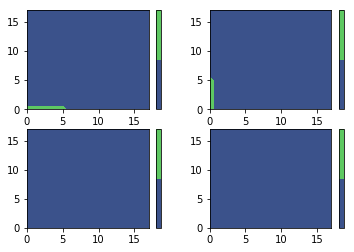

In [7]:
# verify boundary conditions

bcs = np.full((4), None, dtype=DenseMatrix)
for i in range(4):
    bcs[i] = DenseMatrix(dimension, dimension, [0]*elements)
    for x in range(dimension):
        for y in range(dimension):
            bcs[i][x, y] = get_bc(x, y, i)


bcs_sub = np.full((4), None, dtype=np.ndarray)
for i in range(4):
    bcs_sub[i] = np.array(bcs[i].subs(bc, bc_val).tolist())
    
for i in range(4):
    plt.subplot(2, 2, i+1)
    cont = plt.contourf(bcs_sub[i], 1)
    plt.colorbar(cont, ticks=np.unique(bcs))
plt.show(cont)

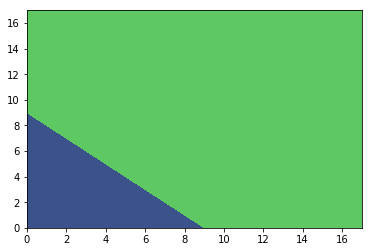

In [8]:
# verify doping
doping = DenseMatrix(dimension, dimension, [0]*elements)
for x in range(dimension):
    for y in range(dimension):
        doping[x, y] = get_doping(x, y)
doping = doping.subs(Na, Na_val).subs(Nd, Nd_val)
cont = plt.contourf(doping.tolist(), 0)
plt.show(cont)

In [9]:
# homogeneous formulation
v_func_homog = DenseMatrix(dimension, dimension, [0]*elements)
for x in range(dimension):
    for y in range(dimension):
        v_func_homog[x, y] = -4*v_sym[x, y]
        for pos in range(4):
            v_func_homog[x, y] = v_func_homog[x, y] + get_neighbor(x, y, pos)

v_coeffs = v_func_homog.reshape(elements, 1).jacobian(v_sym_flat)
v_coeffs = np.array(v_coeffs.tolist(), dtype=np.double)
#v_coeffs

In [10]:
#homogeneous solution
rhs = DenseMatrix(elements, 1, [0]*elements)
for i in range(elements):
    (x, y) = get_xy(i)
    rhs[i] = h*h*-get_doping(x, y)
    for j in range(4):
        rhs[i] = rhs[i] - get_bc(x, y, j)

rhs = np.array(to_val(rhs).tolist(), dtype=np.double)
homog_soln = np.linalg.solve(v_coeffs, rhs)
homog_soln*= Vt
#print homog_soln.reshape((dimension, dimension))
    

In [11]:
# Test solution
sol = homog_soln.reshape((dimension, dimension))

def verify_soln(x, y):
    neighbors = 0
    for i in range(4):
        neighbors += Vt*get_bc(x, y, i) + get_neighbor(x, y, i, sol)
    del2 = to_val((neighbors - 4*sol[x][y])/(h*Ld)**2)
    rhs = to_val((-q*get_doping(x, y)*ni/eps))
    return del2, rhs, del2/rhs
    
print verify_soln(2, 2)[2]
print verify_soln(0, 0)[2]

1.00000000000015
1.00000000000004


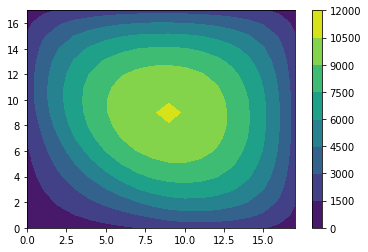

In [12]:
cont = plt.contourf(sol)
plt.colorbar(cont)
plt.show(cont)

In [13]:
# evaluate f(v)
import re
pattern = 'psi_([0-9]+)'
prog = re.compile(pattern)

vfunc_indices = np.empty((elements), dtype=np.ndarray)
for i in range(elements):
    vfunc_indices[i] = np.unique(prog.findall(str(v_func_sym[i]))).astype(int)

def evaluate_f(v_func, soln):
    temp_eval = np.copy(v_func)
    for i in range(elements):
        for j in vfunc_indices[i]:
            temp_eval[i] = temp_eval[i].subs(v_sym_flat[j], soln[j])
    return map(lambda x: x.to_double(), temp_eval)




In [14]:
# evaluate jacobian
# jacobian is independent of bc
jacobian = to_val(jacobian_sym)
jacobian_eval = np.copy(jacobian)
np.fill_diagonal(jacobian_eval, 0)
jacobian_eval = jacobian_eval.astype(np.double)


# to make indexing faster
jacobian_diag = np.diag(jacobian.tolist())

range_index = range(elements)
def evaluate_jacobian(soln):
    for i in range_index:
        jacobian_eval[i][i] = jacobian_diag[i].subs(v_sym_flat[i], soln[i])
    return jacobian_eval

In [15]:
#initial_soln = np.zeros(elements)
#%timeit evaluate_f(initial_soln)
#%timeit evaluate_jacobian(initial_soln)

In [16]:
# solve
source_steps = 18

no_plots = 6
plot_step = int(source_steps/no_plots)
plot_index = 0

v_data = np.empty((no_plots, dimension, dimension), dtype=np.double)
f_data = np.empty((no_plots), dtype=np.ndarray)

max_iterations = 30
tol = 1e-8
initial_sol = np.zeros(elements)

curr_sol = initial_sol
source_step = 0

bc_vals = np.linspace(0, -1/Vt, source_steps)

for source_step in range(source_steps):
    
    bc_val = bc_vals[source_step]
    v_func = np.squeeze(to_val(v_func_sym).tolist())
    f_sol = evaluate_f(v_func, curr_sol)
    f_sum = np.absolute(f_sol).sum()
    min_t = -20
    print'bc = {} :'.format(bc_val*Vt),
    for i in range(max_iterations):
        print '{}..'.format(i), 
        f_sol = evaluate_f(v_func, curr_sol)
        jacobian_sol = evaluate_jacobian(curr_sol)
        del_v = -np.linalg.solve(jacobian_sol, f_sol)
        t = 2
        f_sum = np.absolute(f_sol).sum()
        # line search
        while t > min_t:
            scale = 2**t
            temp_sol = curr_sol + scale*del_v
            temp_f_sol = evaluate_f(v_func, temp_sol)
            temp_sum = np.absolute(temp_f_sol).sum()
            if temp_sum < f_sum:
                curr_sol = temp_sol
                f_sol = temp_f_sol
                break
            #print 't = ', t
            t -= 1
        if t <= min_t:
            print("No t reduces F(V)")
            break
        if temp_sum < tol:
            break
    if source_step % plot_step == 0:
        v_data[plot_index] = Vt*curr_sol.reshape((dimension, dimension))
        f_data[plot_index] = np.array(f_sol).reshape((dimension, dimension))
        plot_index += 1
    print '\n'



    



bc = 0.0 : 0.. 1.. 2.. 3.. 4.. 5.. 6.. 7.. 8.. 9.. 10.. 11.. 12.. 13.. 14.. 15.. 16.. 

bc = -0.0588235294118 : 0.. 1.. 2.. 3.. 

bc = -0.117647058824 : 0.. 1.. 2.. 3.. 

bc = -0.176470588235 : 0.. 1.. 2.. 3.. 

bc = -0.235294117647 : 0.. 1.. 2.. 3.. 

bc = -0.294117647059 : 0.. 1.. 2.. 3.. 

bc = -0.352941176471 : 0.. 1.. 2.. 3.. 

bc = -0.411764705882 : 0.. 1.. 2.. 3.. 

bc = -0.470588235294 : 0.. 1.. 2.. 3.. 

bc = -0.529411764706 : 0.. 1.. 2.. 3.. 

bc = -0.588235294118 : 0.. 1.. 2.. 3.. 

bc = -0.647058823529 : 0.. 1.. 2.. 3.. 

bc = -0.705882352941 : 0.. 1.. 2.. 3.. 

bc = -0.764705882353 : 0.. 1.. 2.. 3.. 

bc = -0.823529411765 : 0.. 1.. 2.. 3.. 

bc = -0.882352941176 : 0.. 1.. 2.. 3.. 

bc = -0.941176470588 : 0.. 1.. 2.. 3.. 

bc = -1.0 : 0.. 1.. 2.. 3.. 



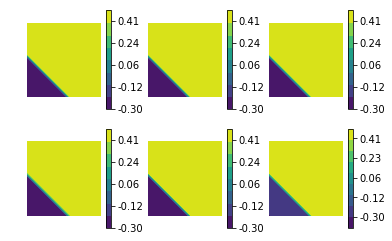

In [17]:
default_plot_size = plt.rcParams['figure.figsize']
#plt.rcParams['figure.figsize'] = [6, 6]

fig, axes = plt.subplots(nrows=2, ncols=3)
axes = axes.flat

for i in range(no_plots):
    ax = axes[i]
    cont = ax.contourf(v_data[i])
    ticks = np.linspace(v_data[i].min(), v_data[i].max(), 5)
    plt.colorbar(cont, ax=ax, ticks=ticks, format='%.2f')
    ax.axis('off')
    ax.set_aspect('equal')
    plot_index += 1

plt.subplots_adjust(wspace=0.3)
plt.show()
plt.rcParams['figure.figsize'] = default_plot_size

In [18]:
v_data.max()

0.41375815577403896

<IPython.core.display.Javascript object>


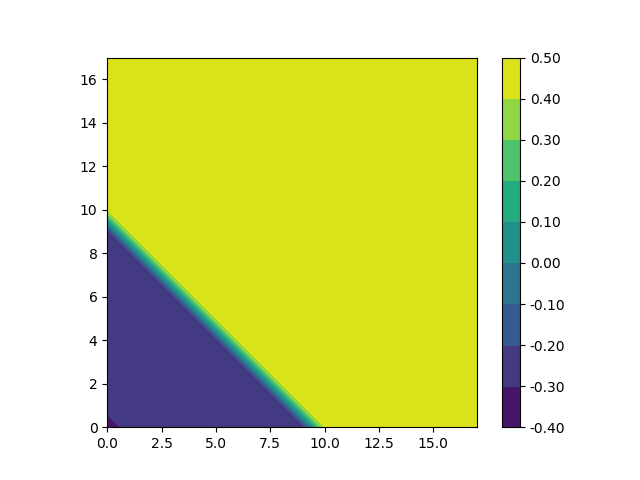

In [25]:
%matplotlib notebook
cont = plt.contourf(v_data[-1])
plt.colorbar(cont, ax=cont.ax, format='%.2f')
cont.ax.set_aspect('equal')
plt.show()

<IPython.core.display.Javascript object>


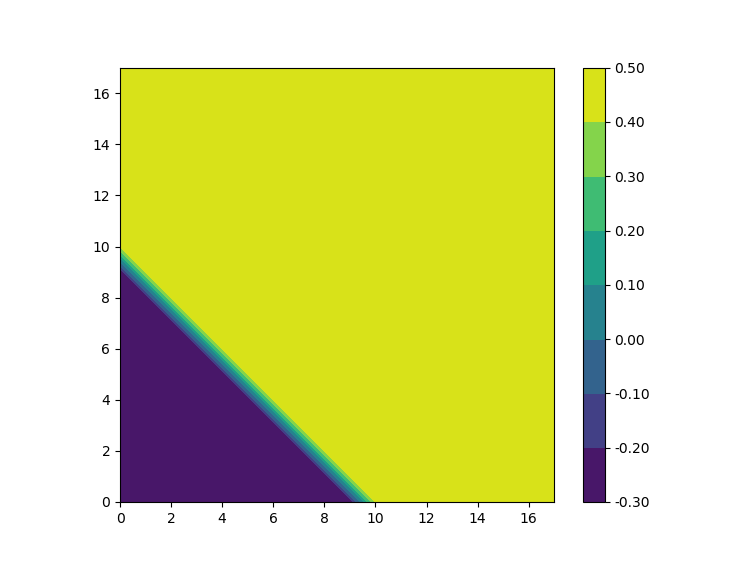

In [39]:
%matplotlib notebook
#cont = plt.contourf(v_data[0], vmax=0.5, vmin=-0.5)
cont = plt.contourf(v_data[0])
plt.colorbar(cont, ax=cont.ax, format='%.2f')
cont.ax.set_aspect('equal')
plt.show()

In [37]:
v_data[0][0][0]

-0.29182775725095933